# Module import

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split

##부모파일에 있는 py파일 읽기
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('load_data.py'))))
 
from load_data import load_data_using_multi_process
from model import model_lgbm
from make_roc_curve import make_roc_curve

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score

/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# data load

In [2]:
fan_path = '/data/time_series/fan'
fan_files = glob.glob(fan_path + '/*/*/*/*')

sr = 16000
target_sr = 125
result = load_data_using_multi_process(files = fan_files, sr = sr, target_sr = target_sr)


아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: soxr_lq

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 5.642566204071045 ---


In [4]:
len(result), len(result[0][0])

(16650, 1251)

In [5]:
all_fan = [one[0] for one in result]


In [6]:
len(all_fan), len(all_fan[0])

(16650, 1251)

In [7]:
df = pd.DataFrame(all_fan)

split

In [13]:
if df.columns[-1] == target_sr*10 :
    df.rename(columns={target_sr*10:'label'}, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,0.002363,-0.001046,-0.000688,0.000679,-0.000117,-0.001900,-0.000505,0.002023,0.000466,0.001408,...,0.000637,-0.001692,-0.001678,0.003447,0.001538,-0.001466,-0.000163,-0.000870,-0.001322,0.0
1,0.002328,-0.000944,0.001628,0.000592,-0.002903,-0.000626,0.000791,-0.000558,-0.000845,0.002327,...,0.002048,-0.001089,-0.000561,0.001379,-0.000938,0.000752,-0.001326,-0.003325,0.002545,0.0
2,-0.000382,0.000388,0.001563,0.001894,-0.001183,-0.000371,-0.001716,-0.002288,0.001621,0.001014,...,0.001534,0.000074,-0.002337,0.000661,-0.001428,0.000356,0.001857,-0.001395,0.000856,0.0
3,-0.001214,0.000303,0.001091,-0.001070,0.000696,0.000749,-0.000512,0.001539,-0.000620,-0.000664,...,-0.000109,-0.000757,0.001035,-0.000620,0.000732,0.000370,-0.001684,0.000572,0.000938,0.0
4,-0.000152,0.001341,0.001614,-0.004479,0.001846,0.002708,-0.002796,0.002506,-0.001309,-0.001511,...,-0.001728,0.002203,-0.000244,-0.000826,0.001080,-0.001809,0.000622,0.000249,0.000213,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,-0.003358,0.001260,-0.000175,-0.002945,-0.000131,0.000004,0.002636,-0.000036,-0.000123,-0.000354,...,0.002548,0.000429,0.000344,-0.001143,-0.002542,0.001105,0.000697,0.002619,-0.001087,1.0
16646,-0.000804,-0.000624,-0.001183,-0.000623,0.000216,0.001757,0.000654,-0.001382,-0.001207,-0.000639,...,0.002133,0.000519,-0.001659,-0.000656,-0.000508,0.000908,0.001500,-0.000596,-0.001546,1.0
16647,0.001636,0.003068,-0.000737,-0.000752,-0.002758,0.000779,0.003397,-0.001045,-0.001359,-0.000763,...,0.002819,0.002043,-0.003972,-0.001538,-0.000635,0.001800,0.002949,-0.001940,-0.000628,1.0
16648,0.000704,-0.004175,0.000913,-0.000389,0.000365,0.002629,-0.001297,-0.001821,-0.000634,0.000539,...,0.000423,-0.000816,0.000343,0.002192,-0.000650,-0.001727,-0.001771,0.000746,0.000229,1.0


# Data Split

In [14]:
X = df.iloc[:, :target_sr*10]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 42)
print('X_train 의 크기 : ', X_train.shape)
print('X_test 의 크기 : ', X_test.shape)
print('y_train 의 크기 : ', y_train.shape)
print('y_test 의 크기 : ', y_test.shape)

X_train 의 크기 :  (13320, 1250)
X_test 의 크기 :  (3330, 1250)
y_train 의 크기 :  (13320,)
y_test 의 크기 :  (3330,)


In [15]:
print(y_train.value_counts())

0.0    9780
1.0    3540
Name: label, dtype: int64


In [16]:
print(y_test.value_counts())

0.0    2445
1.0     885
Name: label, dtype: int64


In [17]:
model = model_lgbm(df)

normal : 12225
abnormal : 4425
scale_pos_weight is 2.76.
Model is ready to running.


# Modeling

In [18]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


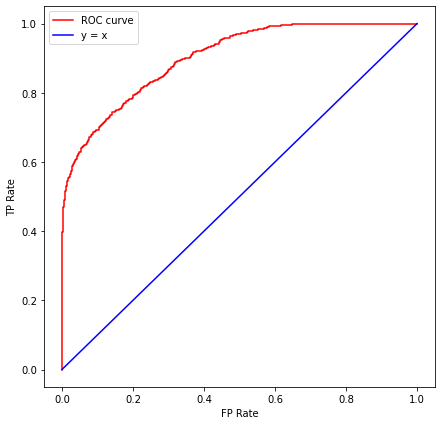

acc_score : 0.868
recall_score : 0.577
precision_score : 0.886
f1_score : 0.699
roc auc value : 0.901


(0.868, 0.699, 0.577, 0.886)

In [19]:
make_roc_curve(y_test, y_pred, y_pred_prob)